In [14]:
# all data sourced from https://www.kaggle.com/hm-land-registry/uk-housing-prices-paid
""" important note conveyancy can take 6-8 weeks - this means that from accepting offer to 
Date of Transfer could be two months different - this will be accounted for later in document"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model
from sklearn.svm import SVR
import datetime

#D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other 
def property_filter_out(data,col,filter_out=''):
    # Function to filter out data from certain column
    for item in filter_out:
        data = data[data[col]!=item]
    return data

In [ ]:
# Load data
housing_df = pd.read_csv('price_paid_records.csv')
# Display head of data
print(housing_df.head())

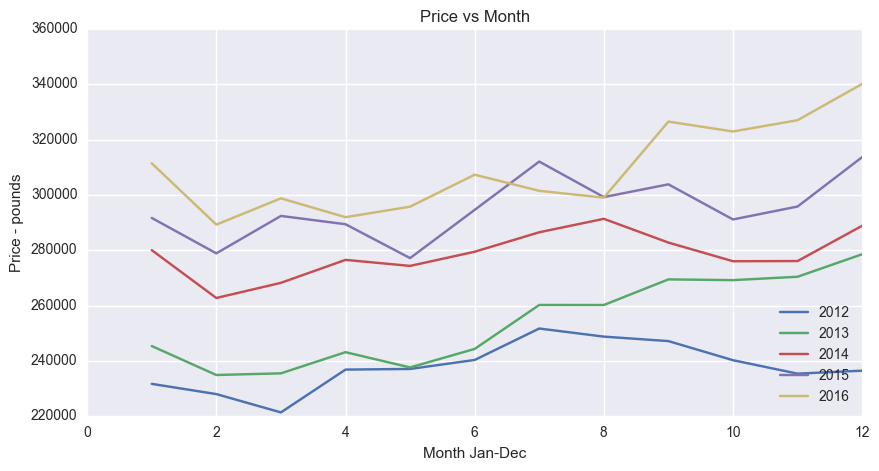

In [17]:
# filter out data we don't want 
#housing_df = property_filter_out(housing_df,'Property Type','TFO')
# Convert the date column to actual datetime + create month/year columns
housing_df['Date of Transfer'] = pd.to_datetime(housing_df['Date of Transfer'],dayfirst=True)
housing_df['Est Date of Agreement'] = np.array(housing_df['Date of Transfer'])-np.timedelta64(8,'W')
housing_df['Year'] = housing_df['Date of Transfer'].dt.year
housing_df['Month'] = housing_df['Date of Transfer'].dt.month

# Create a pivot table of data and select only the last 10 years
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2012,2017)
housing_pivot = housing_pivot[time_range]
# Plot data
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.plot(housing_pivot)
plt.legend(time_range,loc=4)
plt.xlabel('Month Jan-Dec')
plt.ylabel("Price - pounds")
plt.title("Price vs Month")
plt.show()

# Regional Comparison

Looking at difference across regions. There appear to be some serious outliers. Data appears to be right tailed from histogram (see below), but as can be seen 97% of the data lies within 1 standard deviation of the mean.

In [39]:
regional_pivot = pd.pivot_table(housing_df[housing_df['Year']==2016],values='Price',index='District')
#plt.boxplot(regional_pivot,vert=True)
regional_mean = np.mean(regional_pivot)
regional_std = np.std(regional_pivot)
print('Mean Price: {0}'.format(regional_mean))
print('Standard Deviation: {0}'.format(regional_std))

Mean Price: 326261.816091954
Standard Deviation: 354748.0290242051


In [48]:
n = regional_pivot.size
for deviation in [1,2,3]:
    x_std = regional_pivot[(regional_pivot<regional_mean+regional_std*deviation) & (regional_pivot>regional_mean-regional_std*deviation)].size
    print('{0}% of data is within {1} standard deviations of the mean'.format(100*np.round(x_std/n,2),deviation))

97.0% of data is within 1 standard deviations of the mean
99.0% of data is within 2 standard deviations of the mean
99.0% of data is within 3 standard deviations of the mean


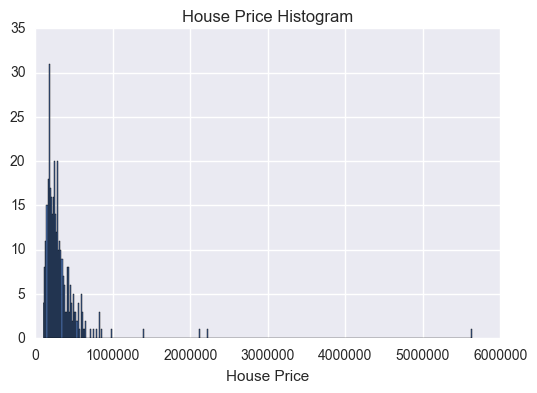

In [38]:
plt.hist(regional_pivot,bins=400)
plt.title('House Price Histogram')
plt.xlabel('House Price')
plt.show()

The below boxplot clearly shows the spread of data, with the median falling below the mean. For any trends examined, there will have to be particular attention paid to regional outliers.

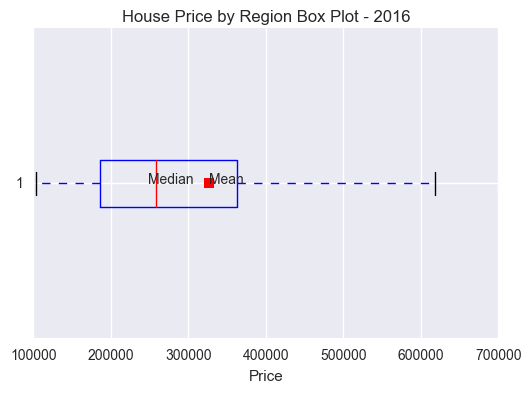

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(regional_pivot,vert=False,showfliers=False,showmeans=True)
plt.title('House Price by Region Box Plot - 2016')
plt.xlabel('Price')
ax.annotate('Median',(np.median(regional_pivot)-9999,1))
ax.annotate('Mean',(regional_mean,1))
plt.show()

Excluding outliers (over 3 standard deviations), we can see that the data is still right tailed. Data is not normally distributed

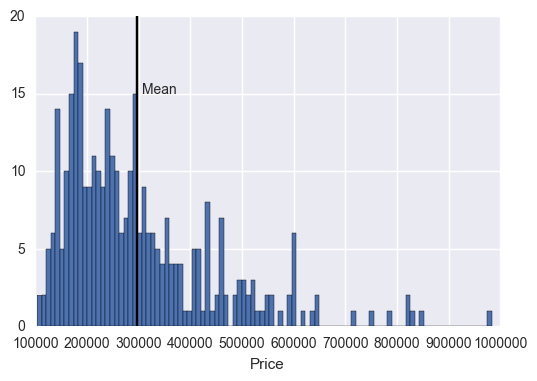

In [113]:
# Without outliers is data normally distributed?
regional_pivot=regional_pivot[regional_pivot<regional_mean+(3*regional_std)]
regional_mean=np.mean(regional_pivot)
plt.hist(regional_pivot,bins=100)
plt.axvline(regional_mean,color='k')
plt.annotate('Mean',(regional_mean+9999,15))
plt.xlabel('Price')
plt.show()

# Result
The above graph appears to show a consistent dip during the beginning of the year and a rise later in the year.

This could potentially be a seasonal shift. Consider that the date used is date of transfer, so the agreed sale could be 2 months prior, which would put the dip around December/January. This could be due to colder weather.

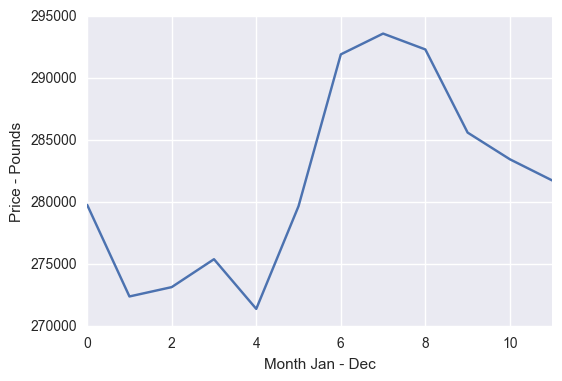

In [38]:
# Take the mean across years for each month - does price really vary by month?
avg_across_years = np.empty((12,1))

for i in range(0,12):
    avg_across_years[i,0] = np.mean(np.array(housing_pivot)[i,:])
plt.plot(avg_across_years)
plt.xlim((0,11))
plt.ylabel('Price - Pounds')
plt.xlabel('Month Jan - Dec')
plt.show()

# Result
This clearly shows that house price varies by time of year. The main dip is around April. 
Does this hold true in all cases? Is this different by region?
Could this difference relate to weather? 

Can we use:
https://www.metoffice.gov.uk/public/weather/climate-historic/#?tab=climateHistoric
Would this explain the variance from the best fit?

In [ ]:
# All regions:
print(pd.unique(housing_df['County']))

In [7]:
def best_fit(X,y):
    lr = linear_model.LinearRegression()
    X=X.reshape(len(X),1)
    y=y.reshape(len(y),1)
    lr.fit(X,y)
    return lr.predict(X)
def region_plot(county,year_start=2015,year_end=2017):
    # function to plot regio separately
    housing_pivot = pd.pivot_table(housing_df[housing_df['County']==county],values='Price',index='Month',columns='Year',aggfunc='mean')
    time_range = np.arange(year_start,year_end)
    housing_pivot = housing_pivot[time_range]
    X=np.array(housing_pivot.index)
    for year in time_range:
        y=housing_pivot[year]
        housing_pivot['{0}_BestFit'.format(year)]=best_fit(X,y)
    # Plot data
    plt.figure(figsize=(10,5))
    plt.subplot(1,1,1)
    plt.plot(housing_pivot)
    plt.legend(housing_pivot.columns,loc=4)
    plt.xlabel('Month Jan-Dec')
    plt.ylabel("Price - pounds")
    plt.title("Price vs Month")
    plt.show()
    return housing_pivot

# Temperature data
Data was sourced for the UK as a whole. Analysis was to be done to establish if temperature could be the cause of this change in house price. Analysis is done using a linear regression for predicting house price.

source: https://www.statista.com/statistics/322658/monthly-average-daily-temperatures-in-the-united-kingdom-uk/
(saved as file weatherAverage.xlsx)

In [8]:
uk_temp_df = pd.read_excel('weatherAverage.xlsx')

In [40]:
# Create pivot table of housing data by month & year
housing_pivot = pd.pivot_table(housing_df,values='Price',index='Month',columns='Year',aggfunc='mean')
time_range = np.arange(2013,2017)
housing_pivot = housing_pivot[time_range]

Year,2013,2014,2015,2016
Month,,,,
1,268005.161945,275996.144230,292495.791675,306812.399235
2,255050.644734,270267.456484,284106.245751,299285.554082
3,257427.276566,264910.180133,279904.958446,318789.558252
4,264323.927295,276323.276140,286356.771504,289688.866732
5,255967.751911,271168.218055,279891.872982,290754.544746
6,264957.660354,276660.570082,291637.976657,304684.755594
7,276366.362852,295889.353413,303721.399694,309392.920409
8,278996.067473,295718.958578,307157.252348,312653.203663
9,276657.556044,292357.397839,308973.628422,312743.375449


In [41]:
# Create training data to test if temperature is relevant
first = True
for year in time_range:
    temp_arr = np.ones((12,5))
    if year==time_range[0]:
        time_arr = np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')
    else:
        time_arr = np.concatenate((time_arr,np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')),axis=0)
    temp_arr[:,0] = np.array([np.datetime64("{0}-{1}-{2}".format(str(year),'{:02d}'.format(m),'01')) for m in housing_pivot.index],dtype='datetime64')
    # weather
    temp_arr[:,2] = np.array(uk_temp_df[str(year)])
    # weather squared - not currently used
    #temp_arr[:,3] = np.array(uk_temp_df[str(year)])**2
    # price
    temp_arr[:,3] = np.array(housing_pivot[year])
    if first == True:
        X = temp_arr[:,:3]
        y = temp_arr[:,3]
        first = False
    else:
        X = np.concatenate((X,temp_arr[:,:3]),axis=0)
        y = np.concatenate((y,temp_arr[:,3]),axis=0)
X_titles = ['Date','One','Temperature']

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr_simple = linear_model.LinearRegression()
lr_simple.fit(X_train,y_train)
prediction = lr_simple.predict(X_test)
#from sklearn.metrics import mean_squared_error
#print(confusion_matrix(prediction,y_test))
#print(classification_report(prediction,y_test))
print('R2 score: {0}'.format(lr_simple.score(X_test,y_test)))
print(['{0}: {1}'.format(X_titles[coef],int(lr_simple.coef_[coef])) for coef in range(len(lr_simple.coef_))])


R2 score: 0.7271934359484347
['Date: 37', 'One: 0', 'Temperature: 687']


# Result of Linear Regression
With an R2 score of 73%, this seems a fairly accurate result. However, is temperature really a good predictor, or is it more that temperature indicates what time of year it is? Month and temperature will be correlated variables. People could be expected to purchase less houses around the Winter months due to other obligations (Christmas, New Years etc).

Next steps will be to look into why price dips.


# Demand

By looking at volume of purchases would this be a good gauge of demand within the housing market. By assessing if volume is lower we will be able to measure if lower demand is the cause of falling house prices, or is some other factor affecting price?

As below graph shows demand appears lower in Winter months (aside from spike in 2016).

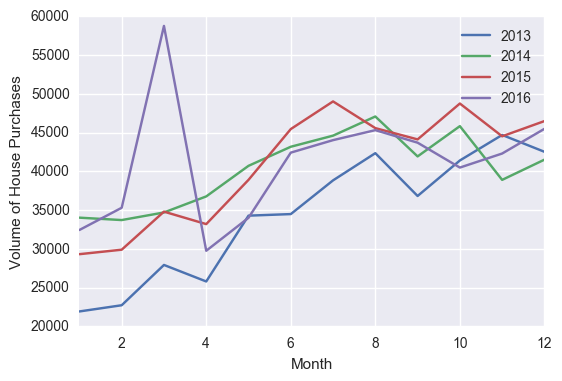

In [39]:
housing_pivot = pd.pivot_table(housing_df,values='Transaction unique identifier',index='Month',columns='Year',aggfunc='count')
time_range = np.arange(2013,2017)
housing_pivot = housing_pivot[time_range]
#plt.axis('square')
plt.xlabel('Month')
plt.xlim((1,12))
plt.ylabel('Volume of House Purchases')
plt.plot(housing_pivot)
plt.legend(time_range)
plt.show()

# Supply

Supply is not considered to be a factor due to the inelastic nature of housing supply. It is not believed that it would be possible for an increase in demand to be met by a sudden increase in supply of housing due to the length of time it takes to construct housing. Additionally it seems unlikely that price dips are being caused by seasonal increases in supply of housing to the market.

Potential housing supply source:
https://www.economicshelp.org/blog/7243/housing/housing-supply-in-uk/ 
or
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/710382/Dwelling_Stock_Estimates_2017_England.pdf

or

http://opendatacommunities.org/home